# Dynamic Time Warping
DTW code and examples taken and revised from:
      https://pypi.python.org/pypi/dtw


In [1]:
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 16,4

Populating the interactive namespace from numpy and matplotlib


## DTW basic implementation

In [2]:
def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

#### Define two toy time series

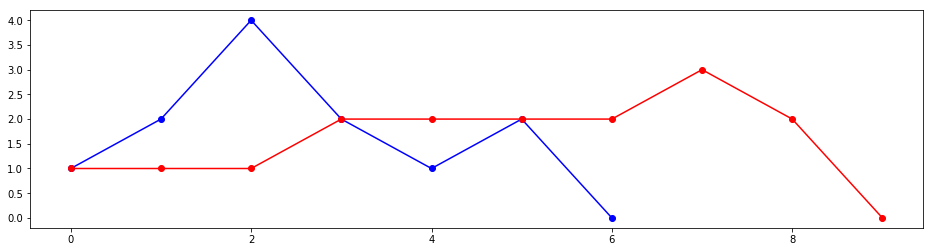

In [3]:
x = array([0, 0, 1, 1, 2, 4, 2, 1, 2, 0])
x = array([1, 2, 4, 2, 1, 2, 0])
y = array([1, 1, 1, 2, 2, 2, 2, 3, 2, 0])
plot(x, 'b-')
plot(x, 'bo')
plot(y, 'r-')
plot(y, 'ro')

#### Define how to compare two points
Our choice: simple |x-y|.

A Euclidean-like possibility is (x-y)^2

In [4]:
def distance(x,y):
    return abs(x-y)

#### Try it!

In [5]:
(dist, cost, acc, path) = dtw(x, y, distance)

In [6]:
dist

2.0

In [7]:
cost

array([[0., 0., 0., 1., 1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 0., 0., 0., 0., 1., 0., 2.],
       [3., 3., 3., 2., 2., 2., 2., 1., 2., 4.],
       [1., 1., 1., 0., 0., 0., 0., 1., 0., 2.],
       [0., 0., 0., 1., 1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 0., 0., 0., 0., 1., 0., 2.],
       [1., 1., 1., 2., 2., 2., 2., 3., 2., 0.]])

In [8]:
acc

array([[0., 0., 0., 1., 2., 3., 4., 6., 7., 8.],
       [1., 1., 1., 0., 0., 0., 0., 1., 1., 3.],
       [4., 4., 4., 2., 2., 2., 2., 1., 3., 5.],
       [5., 5., 5., 2., 2., 2., 2., 2., 1., 3.],
       [5., 5., 5., 3., 3., 3., 3., 4., 2., 2.],
       [6., 6., 6., 3., 3., 3., 3., 4., 2., 4.],
       [7., 7., 7., 5., 5., 5., 5., 6., 4., 2.]])

#### A better table visualization

In [14]:
def nice_table(cost_matrix, title, first_timeseries, second_timeseries):
    import seaborn as sns
    import pandas as pd
    df = pd.DataFrame(cost_matrix.transpose().astype(int))[::-1]
    df.columns = first_timeseries
    df.index = second_timeseries[::-1]
    mask = np.zeros_like(df)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if(np.array(df)[i][j] == -1):
                mask[i][j] = True
    sns.set_context('notebook', font_scale=1.5)
    ax = sns.heatmap(df, annot=True, fmt="d", cbar=False, mask=mask)
    ax.set_title(title)

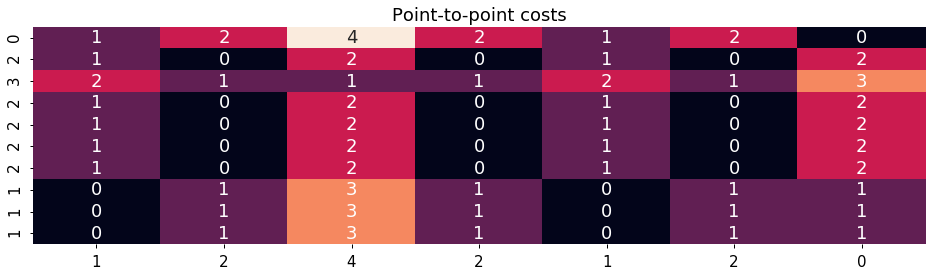

In [15]:
nice_table(cost, 'Point-to-point costs', x, y)

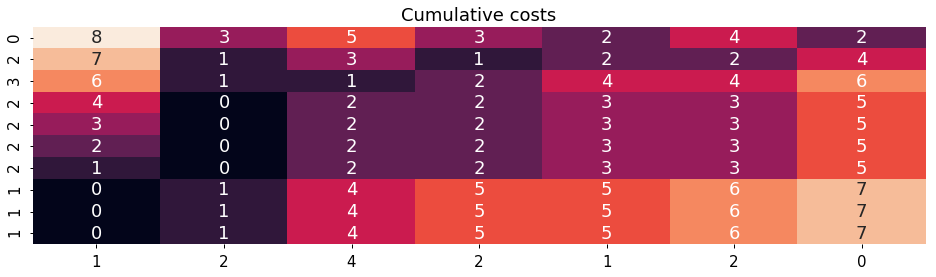

In [16]:
nice_table(acc, 'Cumulative costs', x, y)

In [17]:
path

(array([0, 0, 0, 1, 1, 1, 1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 9]))

In [18]:
for coordinates in zip(path[0],path[1]):
    print coordinates,

(0, 0) (0, 1) (0, 2) (1, 3) (1, 4) (1, 5) (1, 6) (2, 7) (3, 8) (4, 8) (5, 8) (6, 9)


## Plotting the optimal path

In [19]:
def matrix_and_best_path(mymatrix,path):
    import seaborn as sns
    sns.reset_orig()
    sns.set_context('notebook', font_scale=2.5)
    imshow(mymatrix.T, origin='lower', cmap=cm.gray, interpolation='nearest')
    title('Optimal path')
    plot(path[0], path[0], 'c-')
    plot(path[0], path[1], 'y')
    plot(path[0], path[1], 'ro')
    xlim(-0.5,mymatrix.shape[0]-0.5)
    ylim(-0.5,mymatrix.shape[1]-0.5)

#### Path w.r.t cumulative costs

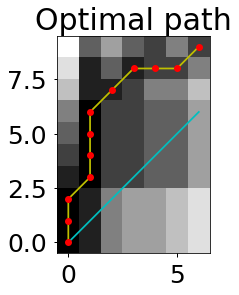

In [20]:
matrix_and_best_path(acc,path)

#### Path w.r.t point-to-point costs

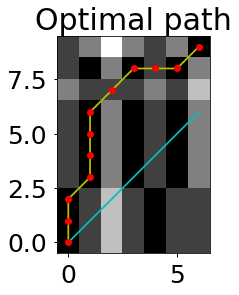

In [21]:
matrix_and_best_path(cost,path)

### Plot DTW alignment plot

In [22]:
path, x, y

((array([0, 0, 0, 1, 1, 1, 1, 2, 3, 4, 5, 6]),
  array([0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 9])),
 array([1, 2, 4, 2, 1, 2, 0]),
 array([1, 1, 1, 2, 2, 2, 2, 3, 2, 0]))

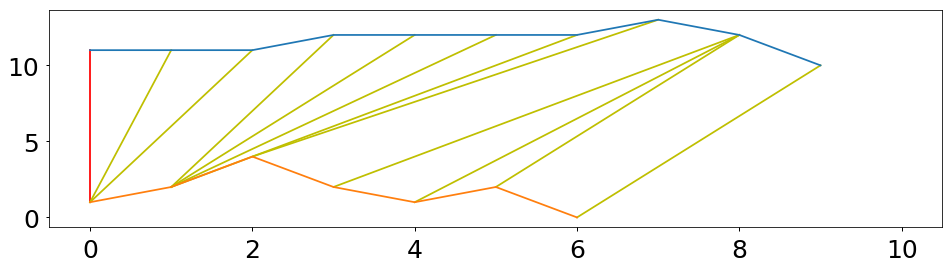

In [24]:
yshift = 10  # shifts y a bit to make the plot more readable
for (i,j) in zip(path[0],path[1]):
    col = 'r-' if i == j else 'y-'
    plot([ i, j ] , [ x[i], y[j]+yshift ], col)
xlim(-0.5,max(len(x),len(y))+0.5)
plot(y+yshift)
plot(x)

## Example on a sound waves dataset

In [26]:
import librosa
y, sr = librosa.load('sounds_0.wav')
y2, sr2 = librosa.load('sounds_8.wav')

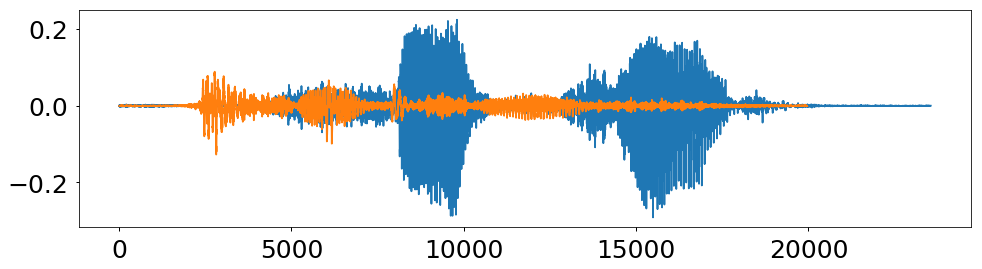

In [27]:
import pandas as pd
rcParams['figure.figsize'] = 16,4

winsmooth = 100
ysmooth = pd.Series(abs(y)).rolling(window=winsmooth).mean()
ysmooth2 = pd.Series(abs(y2)).rolling(window=winsmooth).mean()

samples = [winsmooth*i for i in range(len(ysmooth)/winsmooth)]
samples2 = [winsmooth*i for i in range(len(ysmooth2)/winsmooth)]

plot(y2)
plot(y)


#### Take a sample of size 100 in the middle

0.0026146886 -0.00026167606 0.011204041 0.020154573


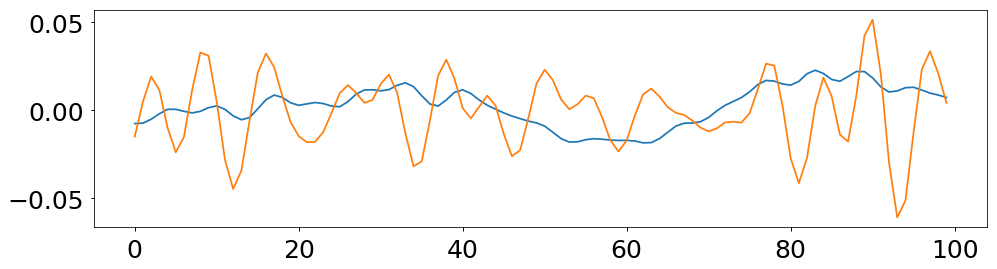

In [28]:
rcParams['figure.figsize'] = 16,4
offset = 5200
win = 100
ys = y[offset:(offset+win)]
ys2 = y2[offset:(offset+win)]
# Normalize
#ys = (ys - ys.mean()) / ys.std()
#ys2 = (ys2 - ys2.mean()) / ys2.std()
plot(ys)
plot(ys2)
print ys.mean(), ys2.mean(), ys.std(), ys2.std()

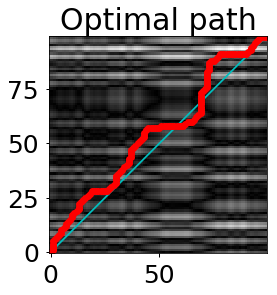

In [29]:
d, aa, cc, ll = dtw(ys,ys2,distance)
matrix_and_best_path(aa,ll)

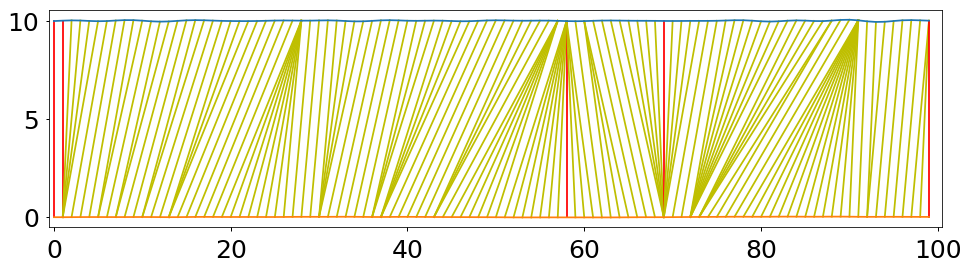

In [30]:
rcParams['figure.figsize'] = 16,4

yshift = 10  # shifts y a bit to make the plot more readable
for (i,j) in zip(ll[0],ll[1]):
    col = 'r-' if i == j else 'y-'
    plot([ i, j ] , [ ys[i], ys2[j]+yshift ], col)
xlim(-0.5,max(len(ys),len(ys2))+0.5)
plot(ys2+yshift)
plot(ys)